In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import mlflow 
import mlflow.keras
import os
import joblib

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


2024-12-17 04:13:26.792849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734408806.804074   79328 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734408806.807312   79328 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 04:13:26.819457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = '/home/abdullah/ai_workspace/project/Stock_prediction_project/initial_training/data/raw_data/HistoricalData.csv'
df_dataset = pd.read_csv(path)

# remove dollar sign from the column

df_dataset["High"] = df_dataset["High"].str.replace("$", "")
df_dataset["Low"] = df_dataset["Low"].str.replace("$", "")
df_dataset["Open"] = df_dataset["Open"].str.replace("$", "")
df_dataset["Close/Last"] = df_dataset["Close/Last"].str.replace("$", "")

# convert all vlues to float

df_dataset["High"] = df_dataset["High"].astype(float)
df_dataset["Low"] = df_dataset["Low"].astype(float)
df_dataset["Open"] = df_dataset["Open"].astype(float)
df_dataset["Close/Last"] = df_dataset["Close/Last"].astype(float)

# convert date to datetime
df_dataset["Date"] = pd.to_datetime(df_dataset["Date"])

# sort the data by date
df_dataset = df_dataset.sort_values(by="Date", ascending=True)

df_dataset.tail()

,Date,Close/Last,Volume,Open,High,Low
4,2024-11-18,140.15,221866000,139.50,141.55,137.15
3,2024-11-19,147.01,227834900,141.32,147.13,140.99
2,2024-11-20,145.89,309871700,147.41,147.56,142.73
1,2024-11-21,146.67,400946600,149.35,152.89,140.70
0,2024-11-22,141.95,236406200,145.93,147.16,141.10


In [3]:
nvda_close = df_dataset["Close/Last"]
nvda_close = nvda_close.values
#nvda_close = nvda_close.reshape(-1, 1)

print(nvda_close.shape)

(2516,)


In [4]:
# split the data into training and testing data

test_split = 0.2

train_data, test_data = train_test_split(df_dataset, test_size=test_split, shuffle=False)
train_data.pop("Date")
test_data.pop("Date")

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test data values: {test_data.values[0][0]}")
print(f"Train data values: {train_data.values}")

Train data shape: (2012, 5)
Test data shape: (504, 5)
Test data values: 16.038
Train data values: [[5.1420000e-01 1.8993440e+08 5.1350000e-01 5.1800000e-01 5.1250000e-01]
 [5.2290000e-01 2.1926536e+08 5.1120000e-01 5.2350000e-01 5.1100000e-01]
 [5.2420000e-01 1.2483124e+08 5.2470000e-01 5.2730000e-01 5.2010000e-01]
 ...
 [1.5677000e+01 7.1089360e+08 1.5715000e+01 1.6266000e+01 1.5535000e+01]
 [1.5409000e+01 4.9207170e+08 1.5966000e+01 1.6002000e+01 1.5120000e+01]
 [1.5317000e+01 4.0473930e+08 1.5147000e+01 1.5477000e+01 1.5080000e+01]]


In [5]:

sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled = sc.fit_transform(train_data)

In [6]:
X_train = []
y_train = []
for i in range(60, train_set_scaled.shape[0]):
    X_train.append(train_set_scaled[i-60:i, 0])
    y_train.append(train_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (1952, 60, 1)
y_train shape: (1952,)


In [7]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

I0000 00:00:1734408809.027264   79328 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1035 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:2b:00.0, compute capability: 8.9
/home/abdullah/ai_workspace/project/Stock_prediction_project/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


I0000 00:00:1734408811.172082   79394 cuda_dnn.cc:529] Loaded cuDNN version 90300


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0249
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015
Epoch 13/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015
Epoch 14/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015
Epoch 15/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 

In [8]:
dataset_total = pd.concat((train_data, test_data), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_data) - 60:].values
# Remove reshaping to maintain all 5 features
inputs = sc.transform(inputs)
X_test = []
for i in range(60, inputs.shape[0]):

    X_test.append(inputs[i-60:i, 0])  # Use the first feature for prediction
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# Create an array with zeros for the other four features
zeros = np.zeros((predicted_stock_price.shape[0], 4))
# Concatenate the predicted_stock_price with zeros
predicted_full = np.concatenate((predicted_stock_price, zeros), axis=1)
# Inverse transform and extract the first column
predicted_stock_price = sc.inverse_transform(predicted_full)[:, 0].reshape(-1, 1)

 1/16 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step

/home/abdullah/ai_workspace/project/Stock_prediction_project/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


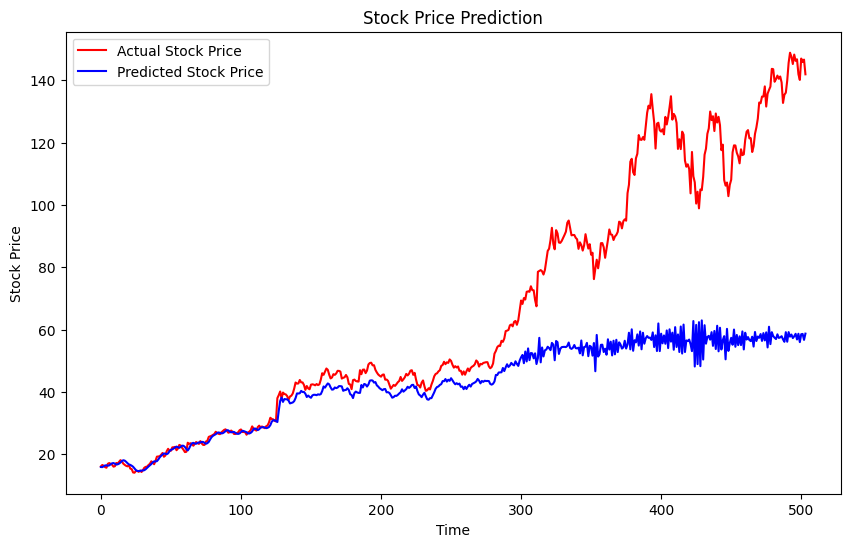

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(test_data['Close/Last'].values, color='red', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [10]:
print(test_data['Close/Last'].values)

[ 16.038   16.519   16.27    15.827   15.639   16.923   17.135   16.876
  16.61    15.987   16.12    17.169   17.001   17.535   18.072   17.674
  16.952   16.571   16.254   16.085   16.501   15.339   15.206   14.121
  14.036   14.603   14.614   14.315   14.749   14.265   14.859   15.628
  15.909   16.001   16.511   16.899   17.702   17.377   16.765   17.839
  19.193   19.265   19.323   19.802   20.365   19.162   19.537   20.943
  21.709   21.1     21.089   22.173   22.205   22.337   21.265   21.788
  22.971   22.764   22.002   21.388   20.655   20.754   23.664   23.286
  23.501   23.216   22.698   23.314   23.89    23.554   23.288   24.181
  23.436   22.965   22.966   24.063   24.228   25.541   25.725   25.9
  26.199   26.468   27.191   26.779   26.531   26.41    26.984   27.383
  27.777   27.965   27.453   26.881   27.037   27.579   27.169   26.495
  26.463   26.758   27.002   27.667   27.931   27.104   27.119   27.042
  26.241   26.956   27.226   27.749   28.91    28.21    27.802   2